<h1>What makes a good restaurant business a good business?</h1>

There are 2 ways to find answer to above question - 
<B>
1. Manual processing of all reviews - very tedious
2. Using NLP to process customer reviews
</B>
This program identifies a path to solve questions like above using 2nd approach. It can be scaled using a containers, but to explain the generic concept below limited version of the code would suffix

Send me your suggestions/comments to ram.nagpure@gmail.com


<B> Step 1 </B>: Get access to YELP using following procedures and call the API to get data -

<ol type="a">
  <li>visit https://www.yelp.com/fusion</li>
  <li>create account</li>
  <li>once the account is validated, create new app</li>
  <li>On the create new app form, enter information about your app accordingly, then agree to Yelp API Terms of Use and Display Requirements. Then click the “Submit” button.</li>
    <li>Now you can get the client_id and key (app secret key) on this page.</li>
</ol>

In [1]:
client_id = <enter your appid>
key = <enter your key>
endpoint_url = 'https://api.yelp.com/v3/businesses/search'
params = {'term':'restaurant',
             'limit':50, #only max 50 is allowed
             'radius':40000, #only max 40k
             'location':'Princeton'}

In [2]:
import pandas as pd
from IPython.display import display, HTML
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from reviews_nlp import getYelpBusinessData, getYelpUserReviews, transformTBData

data  = getYelpBusinessData(url=endpoint_url, params= params, key=key)

<B> Step-2 </B> Create data frame from available data

In [3]:
columns = ['id','name','category','city','distance','overall_rating','display_address','price','review_count']
data_list = [ [item['id'], item['name'], item['categories'][0]['title'],\
               item['location']['city'], \
               item.get('distance', None), item.get('rating', None), \
               "".join(item['location']['display_address']), \
               item.get('price', None),item.get('review_count', 0) ] \
                 for item in data['businesses'] ]

df = pd.DataFrame(data_list, columns = columns)

<B> Step-3 </B> Study data to identify normalized set for further analysis. Once the data is finalized restrict your analysis to <B>best businesses</B>

In [4]:
rest_by_categories = df.sort_values(by=['category','price','overall_rating','review_count'], ascending=False)
#Provide level playing field for business that charges less
df.loc[df.price.isin(['$']), 'wt_ranking'] = df['overall_rating'] * 10.0 + df['review_count'] / 25.0 * 5.0
df.loc[df.price.isin(['$$']), 'wt_ranking'] = df['overall_rating'] * 10.0 + df['review_count'] / 50.0 * 5.0
df.loc[df.price.isin(['$$$']), 'wt_ranking'] = df['overall_rating'] * 10.0 + df['review_count'] / 75.0 * 5.0
#Identify restuarants in top quintile and order by your ranking
top_quintile_restuarants = df.loc[df.wt_ranking > 75.0]
#top_quintile_restuarants.sort_values(by=['wt_ranking'],ascending=False).head(40)

#Now create list of top most business for further investigations
gb_df= top_quintile_restuarants[["id","name","category","overall_rating","price","wt_ranking"]]
gb_df.sort_values(by=['wt_ranking'],ascending=True)

,id,name,category,overall_rating,price,wt_ranking
1,3g-OXwOHASK8bCuInOfNKg,Blue Point Grill,Seafood,4.0,$$$,76.466667
23,6X8LoS2wHZ10Tp1245bTPA,Osteria Procaccini-Kingston,Italian,4.5,$$,81.100000
46,0drT-6ft3Bn30YrFadEKYw,Teresa Caffe,Italian,3.5,$$,85.100000
20,Y2LHNjCKPbz8qeQR9c5iNA,Mamoun's Falafel,Middle Eastern,4.0,$,93.200000
0,SgXxGCzsf5xhEo5mYpBHEw,Agricola Eatery,American (New),4.0,$$$,95.333333
10,4CXO92H2UsgSI4koZNTBQg,Salt Creek Grille,American (New),4.0,$$,101.800000
12,4k6P_MGDltJpD42BoyAf3Q,Jammin' Crepes,Creperies,4.0,$,104.200000
34,5G0Vy0N4H6c4eIGxb1JPSQ,Hoagie Haven,Sandwiches,4.0,$,148.000000


<B>Step 4 - Collect user reviews for these businesses to run NLP based analysis</B>

test_url = https://api.yelp.com/v3/businesses/4CXO92H2UsgSI4koZNTBQg/reviews

In [5]:
review_details = [] 
for gb_id in gb_df["id"]:
    reviews = getYelpUserReviews(buid=gb_id, key=key)
    for review_dict in reviews:
        review_details.append(review_dict)

col_heads = ["id", "Name", "userID", "userRating", "userComment"]
gb_review = pd.DataFrame(review_details, columns = col_heads)

gb_review['sAnalysis'] = [transformTBData(TextBlob(x)) for x in gb_review['userComment'] ]
#convert df's tuple into its own columns
gb_review[['sentiment', 'subjectivity','keyword', 'sentence']] = \
    pd.DataFrame(gb_review['sAnalysis'].tolist(), index=gb_review.index)

display(HTML(gb_review[['sentence','userRating','userComment','sentiment','subjectivity','keyword']].sort_values(by=['userRating', 'sentiment'],ascending=False).to_html()))



,sentence,userRating,userComment,sentiment,subjectivity,keyword
8,He likes it because they have a nice kid's men...,5,Salt Creek grille is our son's favorite rester...,0.533333,0.833333,nice
19,One of my favorite places to indulge.,5,One of my favorite places to indulge. Nothing ...,0.500000,0.775000,favorite
2,"Alright, first, the food is fantastic!",5,"Alright, first, the food is fantastic! Second,...",0.425000,0.513889,fantastic !
14,I had a great experience at the Mamoun's in Pr...,5,I had a great experience at the Mamoun's in Pr...,0.416667,0.527778,great !
3,"So good\n\nOur waitperson- Virginia, was on to...",5,Our first time and WOW!\n\nThank you helpers f...,0.401562,0.608333,top
15,I absolutely love this place.,5,I absolutely love this place. The facility is ...,0.399000,0.750000,absolutely love
9,The staff always welcoming and attentive....,5,This is probably my favorite brunch / lunch sp...,0.331250,0.689286,attentive
18,It's cheap and f$&@ing delicious.,5,Who doesn't love this place! It's cheap and f$...,0.303571,0.750000,cheap
6,It's freezing cold outside right now and my ho...,5,I just came back from THE most delicious and l...,0.240816,0.547959,right
0,It's a large place with lots of different area...,5,This farm to table is outstanding! The atmosph...,0.195437,0.739484,large


<B>Step 5 </B> Define your own criteria for useful review
    <B>I choose reviews with subjectivity >= 0.45 because most people are subjective in their reviews and that what we want. Subjectivity of 1.0 means reviews are highly subjective, while score of 0.0 means they are highly objective </B>

In [6]:
tempDF = gb_review[['keyword','sentence','userRating','sentiment','subjectivity']]
tempDF = tempDF.loc[ (tempDF.subjectivity >= 0.45)]
display(HTML(tempDF.sort_values(by=['userRating','subjectivity','sentiment'],ascending=False).to_html()))


,keyword,sentence,userRating,sentiment,subjectivity
8,nice,He likes it because they have a nice kid's men...,5,0.533333,0.833333
19,favorite,One of my favorite places to indulge.,5,0.500000,0.775000
15,absolutely love,I absolutely love this place.,5,0.399000,0.750000
18,cheap,It's cheap and f$&@ing delicious.,5,0.303571,0.750000
0,large,It's a large place with lots of different area...,5,0.195437,0.739484
9,attentive,The staff always welcoming and attentive....,5,0.331250,0.689286
3,top,"So good\n\nOur waitperson- Virginia, was on to...",5,0.401562,0.608333
6,right,It's freezing cold outside right now and my ho...,5,0.240816,0.547959
14,great !,I had a great experience at the Mamoun's in Pr...,5,0.416667,0.527778
20,classic,"A Princeton classic: fatty, fried indulgence a...",5,0.036111,0.525000


<B>Step 6 and Final step </B> Create Word Cloud of the analysis

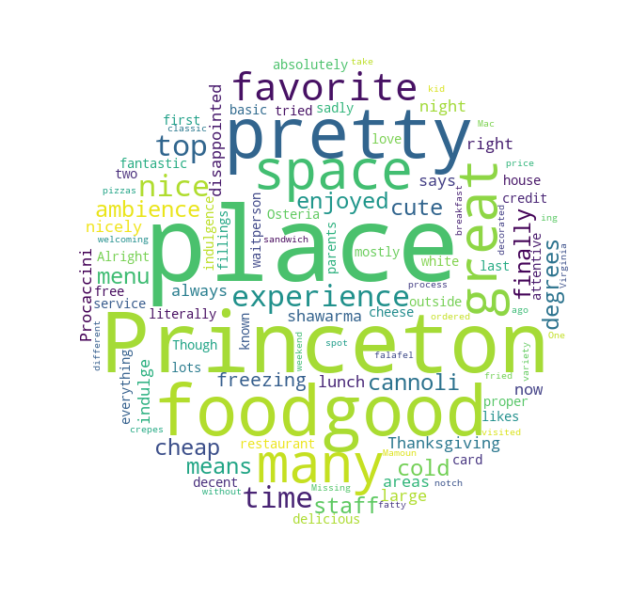

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(sent for sent in tempDF.sentence)
stopwords = set(STOPWORDS) #for now go with standard stopwords from WC

mask = np.array(Image.open("plate_image1.png"))
wordcloud = WordCloud(width=512, height=512, 
                      stopwords=stopwords, max_words=2000, 
                      mask=mask, background_color="white").generate(text)
plt.figure(figsize=(10,8), facecolor='white',edgecolor='blue')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()